<a href="https://colab.research.google.com/github/OktarianTB/predicting-business-popularity/blob/main/calculate_restaurants_edges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculate Restaurant Edges
Program to generate CSV file with edges between restaurants who are less than DIST_MAX meters away from each other.

Using Google Colab.

In [ ]:
import json
import pandas as pd
import numpy as np
import math
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving restaurants_loc_only.csv to restaurants_loc_only (2).csv


### Reading the data

In [ ]:
import io
restaurants_df = pd.read_csv(io.BytesIO(uploaded['restaurants_loc_only.csv']))

In [ ]:
restaurants_df.head(6)

,Unnamed: 0,business_id,city,is_open,latitude,longitude,postal_code,state
0,0,6iYb2HFDywm3zjuRg0shjw,Boulder,1,40.017544,-105.283348,80302,CO
1,1,tCbdrRPZA0oiIYSmHG3J0w,Portland,1,45.588906,-122.593331,97218,OR
2,5,D4JtQNTI4X3KcbzacDJsMw,Vancouver,1,49.251342,-123.101333,V5V,BC
3,12,HPA_qyMEddpAEtFof02ixg,Peabody,1,42.541155,-70.973438,01960,MA
4,13,ufCxltuh56FF4-ZFZ6cVhg,Orlando,1,28.513265,-81.374707,32806,FL
5,16,GfWJ19Js7wX9rwaHQ7KbGw,Orlando,1,28.350498,-81.542819,32830,FL


### Analyzing distribution of locations

In [ ]:
restaurants_df.groupby("state").size().sort_values(ascending=False)

state
MA    8367
FL    6413
OR    6267
BC    6059
GA    5049
TX    4544
OH    3643
CO     685
WA     637
dtype: int64

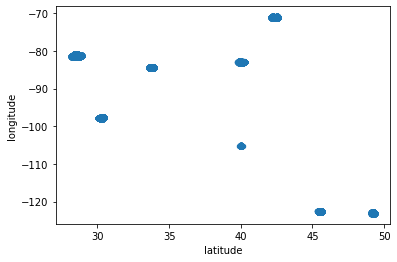

In [ ]:
# Can clearly observe the 8 metropolitan areas
restaurants_df.plot.scatter(x="latitude", y="longitude")

In [ ]:
restaurants_df.groupby("city").size().sort_values(ascending=False)[:10]

city
Portland     4877
Austin       4211
Vancouver    4174
Atlanta      3479
Orlando      3215
Boston       2298
Columbus     2249
Richmond      694
Cambridge     664
Kissimmee     581
dtype: int64

### Get Dataframes for each Metropolitan Areas

In [ ]:
boston_df = restaurants_df[restaurants_df["state"] == "MA"]
vancouver_df = restaurants_df[restaurants_df["state"] == "BC"]
orlando_df = restaurants_df[restaurants_df["state"] == "FL"]
austin_df = restaurants_df[restaurants_df["state"] == "TX"]
portland_df = restaurants_df[restaurants_df["state"].isin(["WA", "OR"])]
atlanta_df = restaurants_df[restaurants_df["state"] == "GA"]
colombus_df = restaurants_df[restaurants_df["state"] == "OH"]
boulder_df = restaurants_df[restaurants_df["state"] == "CO"]

print(f"1. Boston (MA)\t\t{len(boston_df)}")
print(f"2. Vancouver (BC)\t{len(vancouver_df)}")
print(f"3. Orlando (FL)\t\t{len(orlando_df)}")
print(f"4. Austin (TX)\t\t{len(austin_df)}")
print(f"5. Portland (WA/OR)\t{len(portland_df)}")
print(f"6. Atlanta (GA)\t\t{len(atlanta_df)}")
print(f"7. Colombus (OH)\t{len(colombus_df)}")
print(f"8. Boulder (CO)\t\t{len(boulder_df)}")

1. Boston (MA)		8367
2. Vancouver (BC)	6059
3. Orlando (FL)		6413
4. Austin (TX)		4544
5. Portland (WA/OR)	6904
6. Atlanta (GA)		5049
7. Colombus (OH)	3643
8. Boulder (CO)		685


In [ ]:
boulder_df.head()

,Unnamed: 0,business_id,city,is_open,latitude,longitude,postal_code,state
0,0,6iYb2HFDywm3zjuRg0shjw,Boulder,1,40.017544,-105.283348,80302,CO
16,52,Of6xu3pY3eHe2yhiyz2dvg,Boulder,1,40.033678,-105.259103,80301,CO
51,158,_8Hejg5Q-_izIhLvq2ocnw,Boulder,1,40.070694,-105.200376,80301,CO
99,339,hfoHYhD4uzqsHQDxKMFnQw,Boulder,0,40.008353,-105.276600,80302,CO
103,360,Ziix5uzW9hJu5nYDxCmm1Q,Boulder,0,40.017152,-105.255516,80301,CO


### Generate Edges

#### Idea:
- Calculate distance between every location within each metropolitan area (by state)
- Use haversine distance

In [ ]:
DIST_MAX = 500

In [ ]:
edges = [] # each edge is a tuple (id1, id2, distance) representing the business IDs

In [ ]:
metropolitan_areas = [boston_df, vancouver_df, orlando_df, austin_df, portland_df, atlanta_df, colombus_df, boulder_df]

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res*1000, 2)

In [ ]:
edges

[]

In [ ]:
start_time = time.time()
count = 0
print("Processing...")

for index1, row1 in portland_df.iterrows():
    count += 1
    if count % 500 == 0:
      print(f"Current count: {count}")
    for index2, row2 in portland_df[portland_df.index > index1].iterrows():
        dist = haversine_distance(row1[3], row1[4], row2[3], row2[4])
        if dist < DIST_MAX:
            edges.append((row1[0], row2[0], round(dist)))

total_time = (time.time() - start_time) / 60
print(f"Finished area in {round(total_time, 2)}")

Processing...
Current count: 500
Current count: 1000
Current count: 1500
Current count: 2000
Current count: 2500
Current count: 3000
Current count: 3500
Current count: 4000
Current count: 4500
Current count: 5000
Current count: 5500
Current count: 6000
Current count: 6500
Finished area in 50.9


In [ ]:
len(edges)

826806

In [ ]:
edges_df = pd.DataFrame(edges, columns=['id1', 'id2', 'distance'])

In [ ]:
edges_df.head()

,id1,id2,distance
0,1,2087,44
1,1,2168,31
2,1,3191,76
3,1,5283,82
4,1,6699,73


In [ ]:
edges_df.to_csv("./portland_df.csv", index=False)

In [ ]:
files.download("portland_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>